# **Visualisations**

## Objectives
In this notebook, I will explore and communicate key trends in global video game sales to validate my hypotheses about what drives sales performance.  
I will begin with an overview of **global sales trends**, then create targeted visualisations to test each hypothesis — such as the impact of reviews, regional platform strength, and the effect of multi-platform and first-party releases.

## Inputs
I will use the **processed datasets** created during ETL and feature engineering:

- `video_game_sales_cleaned.csv` — base cleaned dataset with essential sales and metadata.
- `video_game_sales_critic_review.csv` — games with valid critic reviews.
- `video_game_sales_user_review.csv` — games with valid user reviews.
- `video_game_sales_merged.csv` — aggregated game-level dataset (platforms merged).
- `video_game_sales_first_party.csv` — dataset with engineered `is_first_party` and `is_multiplatform` columns.

## Outputs
- Visualisations that support each hypothesis:
  - **Global sales trends** over time.
  - Impact of **critic reviews** on sales.
  - Impact of **user reviews** on sales.
  - **Platform strength by region** (Nintendo, Sony, Microsoft, Other).
  - **Multi-platform vs single-platform** sales comparison.
  - **First-party vs third-party** sales comparison.
- Charts and summaries for the final Tableau dashboard.

## Approach
Each visualisation ties directly to one of my hypotheses and Kanban board user stories.  
I will start with a **Global Sales Trend** plot to establish market context, then move into deeper hypothesis testing using the processed datasets.

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/stephenbeese/GitHub/Video-Game-Sales-Analysis/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/stephenbeese/GitHub/Video-Game-Sales-Analysis'

Set up the data directories

In [4]:
# Set the file path for the raw data
raw_data_dir = os.path.join(current_dir, 'data/raw')

# Set the file path for the processed data
processed_data_dir = os.path.join(current_dir, 'data/processed')

# Print file paths
print("Raw data directory:", raw_data_dir)
print("Processed data directory:", processed_data_dir)

Raw data directory: /Users/stephenbeese/GitHub/Video-Game-Sales-Analysis/data/raw
Processed data directory: /Users/stephenbeese/GitHub/Video-Game-Sales-Analysis/data/processed


# Imports

Import the necessary packages to perform the visualisation process.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import linregress, ttest_ind, mannwhitneyu

from utils.validation import run_anova_by_region, run_tukey_by_region

# Load the csv files into dataframes

In [6]:
df_master = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_cleaned.csv'))
df_merged = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_merged.csv'))
df_first_party = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_first_party.csv'))
df_critic_reviews = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_critic_review.csv'))
df_user_reviews = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_user_review.csv'))

### You can view these dataframes [here](display_data.ipynb)

---

# Global Overview

### Global Sales Trends Over Time
- Plot total `Global_Sales` by `Year_of_Release`.
- Highlight peaks (e.g. Wii/DS era, PlayStation boom).

In [7]:
# Aggregate global sales by year
global_sales_by_year = (
    df_master.groupby('Year_of_Release')['Global_Sales']
    .sum()
    .reset_index()
    .sort_values(by='Year_of_Release')
)

# filter out invalid years
global_sales_by_year = global_sales_by_year[global_sales_by_year['Year_of_Release'] > 0]

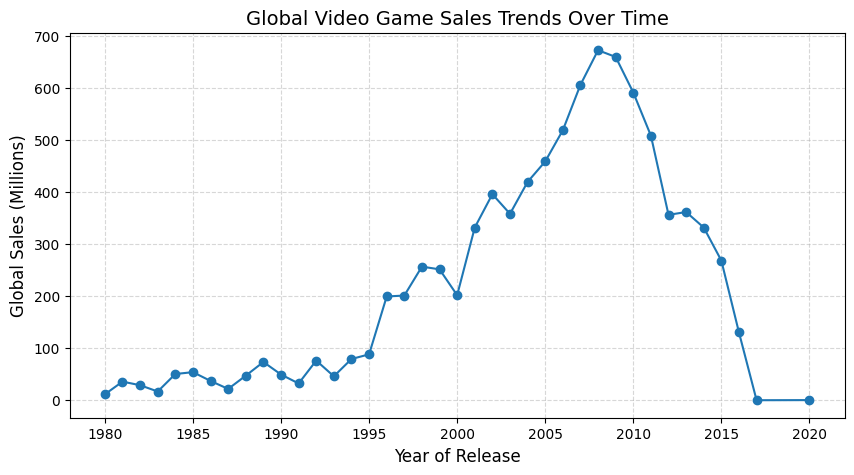

In [8]:
# Plot global sales over time
plt.figure(figsize=(10, 5))
plt.plot(global_sales_by_year["Year_of_Release"], global_sales_by_year["Global_Sales"], marker="o")
plt.title("Global Video Game Sales Trends Over Time", fontsize=14)
plt.xlabel("Year of Release", fontsize=12)
plt.ylabel("Global Sales (Millions)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
# Save the plot
plt.savefig(os.path.join(current_dir, 'images/visualisations/global_sales_trends.png'))

# Show the plot
plt.show()

### Insights from Global Sales Trends

* **Steady Growth (1980s–1990s)**
  * Sales gradually rose as consoles like NES, SNES, and PlayStation became mainstream.

* **Peak Era (2000–2009)**
  - Sharp growth leading to a peak around **2008–2009**, driven by the Wii/DS boom and strong PS3/Xbox 360 releases.

* **Decline After 2009**
  - Sales drop steeply — likely due to digital distribution, mobile gaming, and fewer physical releases.

* **Recent Low Volumes (2015+)**
  - Physical sales remain low as the market shifts to digital downloads, subscriptions, and live-service games.

---
### Average Global Sales Over Time
- Plot average [(mean)](../README.md#core-statistical-concepts) `Global_Sales` by `Year_of_Release`.
- Highlight key shifts in the typical game’s performance

This is useful to understand how the sales per game changed over time — this avoids the distortion caused by years with unusually high numbers of releases and shows the market’s true health.

In [9]:
# Calculate average global sales per game per year
avg_sales_by_year = (
    df_master.groupby('Year_of_Release')['Global_Sales']
    .mean()
    .reset_index()
    .sort_values('Year_of_Release')
)

# Filter out invalid years
avg_sales_by_year = avg_sales_by_year[avg_sales_by_year['Year_of_Release'] > 0]

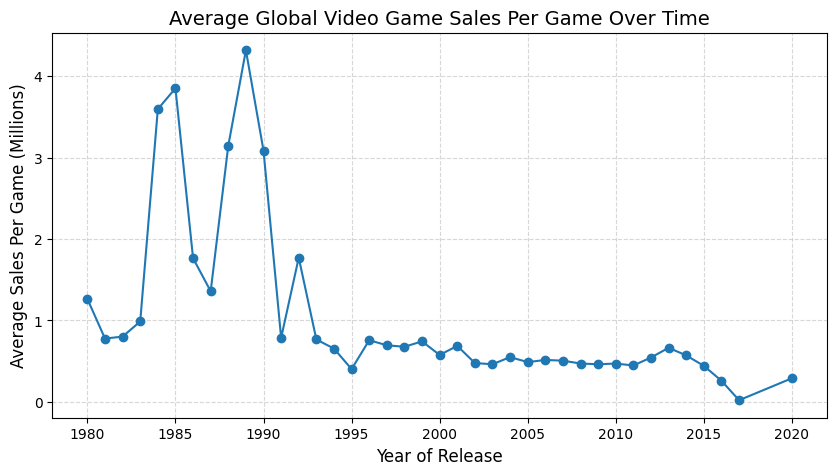

In [10]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(avg_sales_by_year['Year_of_Release'], avg_sales_by_year['Global_Sales'], marker='o')
plt.title('Average Global Video Game Sales Per Game Over Time', fontsize=14)
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Average Sales Per Game (Millions)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Save the plot
plt.savefig(os.path.join(current_dir, 'images/visualisations/average_global_sales_trends.png'))

# Show the plot
plt.show()


### Insights from Average Sales per Game by Year

* **Early spikes are unstable** — Pre-1995 values show sharp peaks and dips likely due to very small sample sizes (few games released per year, so one hit skews the average).
* **Long-term decline** — After the mid-90s, average sales per game dropped and stabilised around ~0.5–1M per title, showing a more saturated market and increased competition.
* **Hit-driven economy** — The steady low average despite total sales growth suggests the market relied on a few mega-hits (e.g., Wii Sports, GTA) while most games sold modestly.
* **Important check** — Outliers and low release counts in early years can distort averages

This plot complements total sales trends. It helps to avoid misleading conclusions (e.g., “sales peaked in 2008”) by showing that while total revenue was high, the *average game* didn’t necessarily sell better.

---
# **Hypothesis Testing**
---

## Hypothesis 1 — Critic Reviews Drive Sales
- **Data:** `video_game_sales_critic_review.csv`
- **Visual:** Scatter plot of `Critic_Score` vs `Global_Sales`  
  - Regression line  
  - Bubble size = `Critic_Count`
- **Validation:** Look for positive correlation & p-value < 0.05.

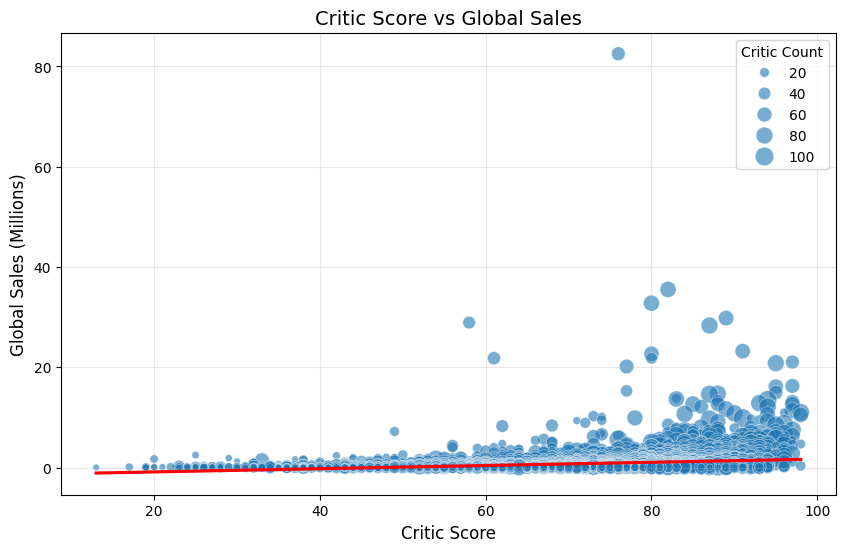

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_critic_reviews,
    x="Critic_Score",
    y="Global_Sales",
    size="Critic_Count",
    sizes=(20, 200),
    alpha=0.6
)
sns.regplot(
    data=df_critic_reviews,
    x="Critic_Score",
    y="Global_Sales",
    scatter=False,
    color="red",
    line_kws={'label':"Regression Line"}
)

plt.title("Critic Score vs Global Sales", fontsize=14)
plt.xlabel("Critic Score", fontsize=12)
plt.ylabel("Global Sales (Millions)", fontsize=12)
plt.legend(title="Critic Count")
plt.grid(alpha=0.3)
# Save the plot
plt.savefig(os.path.join(current_dir, 'images/visualisations/critic_score_vs_global_sales.png'))

# Show the plot
plt.show()



In [12]:
slope, intercept, r_value, p_value, std_err = linregress(
    df_critic_reviews["Critic_Score"], df_critic_reviews["Global_Sales"]
)

print(f"Correlation (r): {r_value:.3f}")
print(f"P-value: {p_value:.5f}")
print(f"Slope: {slope:.3f} (Global sales change per critic point)")


Correlation (r): 0.245
P-value: 0.00000
Slope: 0.032 (Global sales change per critic point)


### Insights — Critic Scores vs Global Sales

The scatter plot shows a **positive but modest correlation** between critic scores and global sales (r = 0.245, p < 0.001). This indicates that games with higher critic scores **tend to sell more**, but the relationship is not very strong.

* **Statistical significance:** The p-value is effectively zero, so the relationship is highly significant.
* **Practical effect:** The slope suggests that for each additional point in critic score, global sales increase on average by ~0.03 million units. While small per point, the effect could accumulate (e.g., a 20-point score difference ≈ 0.6M extra sales).
* **Outliers:** Some blockbuster games with extreme sales overshadow most data points; filtering or using log scale helps to reveal the overall trend.
* **Critic count:** Larger bubbles (higher `Critic_Count`) cluster among higher-scoring and better-selling games, suggesting that games with more reviews are often also more commercially successful.

**Interpretation:**
Critic scores do appear to matter, but they explain only a small portion of sales variation. Other factors (franchise, marketing, platform, genre) likely have a bigger influence on commercial success.

---


Due to the fact that the above graph contains some obvious outliers.

I am going to filter these out to games selling less that 20M copies to create a more typical visualisation.

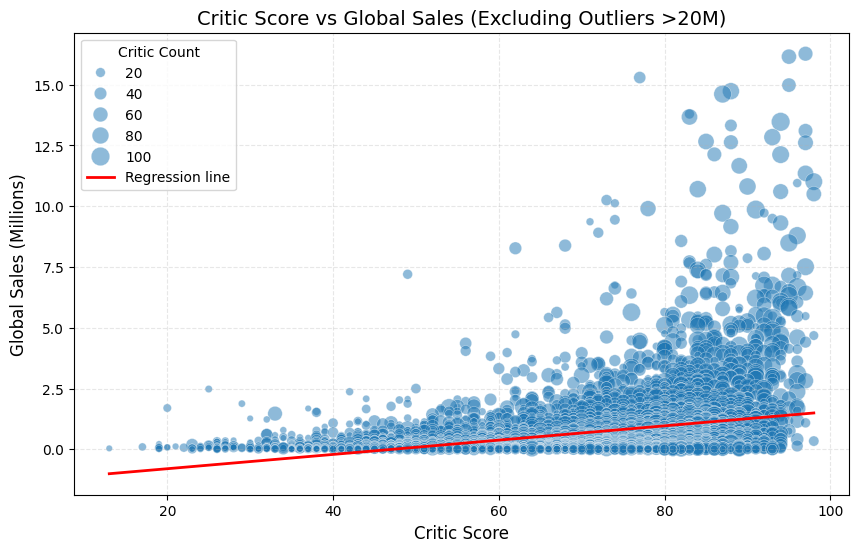

In [13]:
# Filter out extreme outliers for readability (games selling >20M)
filtered_critic = df_critic_reviews[df_critic_reviews["Global_Sales"] <= 20]

plt.figure(figsize=(10, 6))

# Bubble scatter plot using Seaborn
sns.scatterplot(
    data=filtered_critic,
    x="Critic_Score",
    y="Global_Sales",
    size="Critic_Count",
    sizes=(20, 200),      # bubble size range
    alpha=0.5,
    legend="brief"
)

# Regression line (linear fit)
slope, intercept, r_value, p_value, std_err = linregress(
    filtered_critic["Critic_Score"],
    filtered_critic["Global_Sales"]
)

sns.lineplot(
    x=filtered_critic["Critic_Score"],
    y=intercept + slope*filtered_critic["Critic_Score"],
    color="red",
    linewidth=2,
    label="Regression line"
)

# Plot formatting
plt.xlabel("Critic Score", fontsize=12)
plt.ylabel("Global Sales (Millions)", fontsize=12)
plt.title("Critic Score vs Global Sales (Excluding Outliers >20M)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Critic Count")

# Save the plot
plt.savefig(os.path.join(current_dir, 'images/visualisations/critic_score_vs_global_sales_filtered.png'))

# Show the plot
plt.show()



In [14]:
# Display correlation stats
print(f"Correlation (r): {r_value:.3f}")
print(f"P-value: {p_value:.5f}")
print(f"Slope: {slope:.3f} (Global sales change per critic point)")

Correlation (r): 0.331
P-value: 0.00000
Slope: 0.029 (Global sales change per critic point)


### Insights — Critic Reviews Drive Sales (Filtered - <20M Global Sales)

The scatter plot shows a clearer positive correlation between critic scores and global sales once extreme outliers are removed (r = 0.331, p < 0.001). This suggests that critic reviews have a moderate influence on sales.

* **Statistical significance:** The p-value is effectively zero, confirming the relationship is highly significant.
* **Practical effect:** The slope indicates each additional critic point adds about **0.03M sales** on average. A 20-point difference could equate to ~0.6M extra sales.
* **Outliers:** Removing blockbuster hits (>20M sales) improves readability and highlights the general trend.
* **Critic count:** Larger bubbles (higher Critic_Count) still cluster toward higher scores and better sales, showing that widely reviewed, well-rated games tend to sell more.

**Interpretation:** Critic scores appear to have a stronger and clearer link to sales after filtering extreme hits. However, the relationship is still moderate — other commercial drivers such as brand recognition, marketing, and platform likely play major roles.

---

## Hypothesis 1 - Overall Conclusions

### **Higher critic review scores positively influence sales.**

### Statistical Validation

* **Correlation (all data):** r = **0.245** (positive but modest)
* **Correlation (filtered <20M):** r = **0.331** (stronger once extreme hits removed)
* **P-value:** <0.001 in both cases → **highly significant relationship**
* **Slope:** ≈ **0.03M extra sales per 1-point critic score increase**
  → 20-point difference ≈ +0.6M global sales

### Interpretation

* The hypothesis is **statistically supported** — critic scores do have a positive and significant relationship with global sales.
* **However**, the effect size is modest, meaning critic reviews influence sales but don’t fully explain commercial success. Other factors like brand/franchise power, marketing budgets, and platform impact likely play a larger role.
* Filtering extreme outliers made the trend clearer and improved correlation, indicating blockbuster games can distort the overall picture.

**Validation Decision:**
* Hypothesis **ACCEPTED** — critic reviews significantly influence sales, but the impact is moderate rather than dominant.

---

## Hypothesis 2 — User Reviews Drive Sales

* **Data:** `video_game_sales_user_review.csv`
* **Visual:** Scatter plot of `User_Score` vs `Global_Sales`

  * Regression line
  * Bubble size = `User_Count`
* **Validation:** Look for a positive correlation (p-value < 0.05) between user score and global sales.

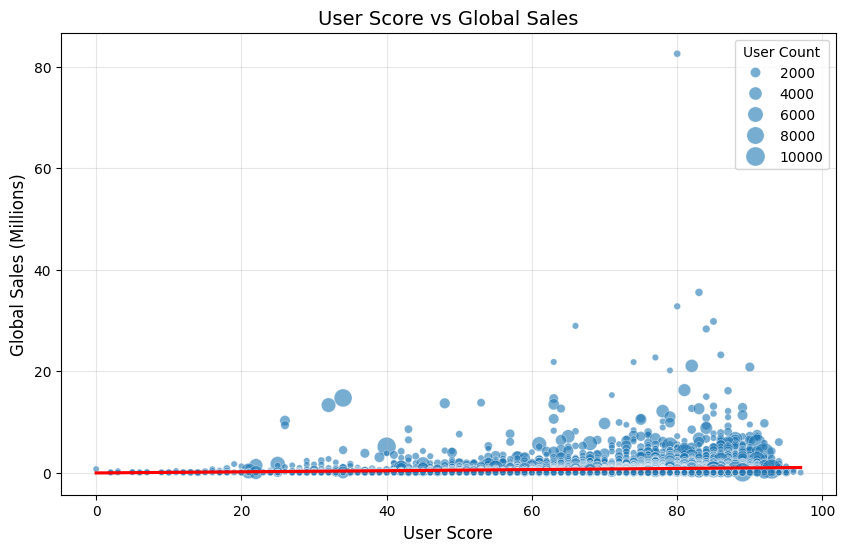

In [15]:
user_score = df_user_reviews["User_Score"] * 10  # Scale to 0-100 for consistency

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_user_reviews,
    x=user_score,
    y="Global_Sales",
    size="User_Count",
    sizes=(20, 200),
    alpha=0.6,
)
sns.regplot(
    data=df_user_reviews,
    x=user_score,
    y="Global_Sales",
    scatter=False,
    color="red",
    line_kws={'label':"Regression Line"}
)

plt.title("User Score vs Global Sales", fontsize=14)
plt.xlabel("User Score", fontsize=12)
plt.ylabel("Global Sales (Millions)", fontsize=12)
plt.legend(title="User Count")
plt.grid(alpha=0.3)
# Save the plot
plt.savefig(os.path.join(current_dir, 'images/visualisations/user_score_vs_global_sales.png'))

# Show the plot
plt.show()

In [16]:
slope, intercept, r_value, p_value, std_err = linregress(
    df_user_reviews["User_Score"], df_user_reviews["Global_Sales"]
)

print(f"Correlation (r): {r_value:.3f}")
print(f"P-value: {p_value:.5f}")
print(f"Slope: {slope:.3f} (Global sales change per user point)")


Correlation (r): 0.088
P-value: 0.00000
Slope: 0.110 (Global sales change per user point)


### Insights — User Scores vs Global Sales

The scatter plot shows a **weak positive correlation** between user scores and global sales (r = 0.088, p < 0.001). This suggests that games with higher user ratings **tend to sell slightly more**, but the relationship is very weak overall.

* **Statistical significance:** The p-value is zero, indicating the relationship is statistically significant but not practically strong.
* **Practical effect:** The slope (0.11) implies that for each additional point in user score (0–100 scale), sales increase on average by about **0.11 million units**, though the overall effect remains minor.
* **Outliers:** A few blockbuster games dominate global sales, overshadowing smaller titles; these outliers may inflate the overall trend slightly.
* **User count:** Larger bubbles (higher `User_Count`) tend to appear among games with higher scores and better sales, indicating that popular, well-rated games attract more user engagement.

**Interpretation:**
While user reviews show a statistically valid connection with sales, the correlation is very small. This implies that **user sentiment alone does not drive sales** — instead, broader factors such as marketing, brand loyalty, and platform availability likely have a much greater influence on commercial success.

---

Similarly to the previous hypothesis the above graph contains some obvious outliers.

I am going to filter these out to games selling less that 20M copies to create a more typical visualisation.

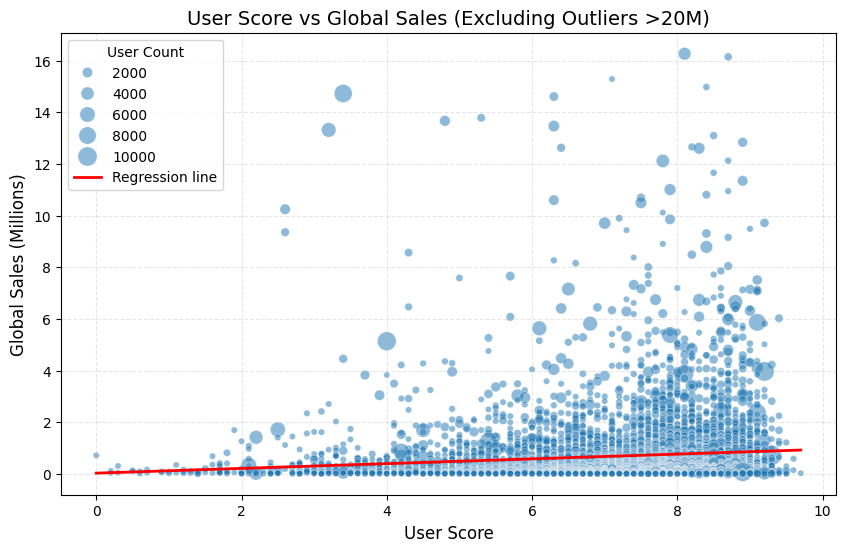

In [17]:
filtered_user = df_user_reviews[df_user_reviews["Global_Sales"] <= 20]

plt.figure(figsize=(10, 6))

# Bubble scatter plot using Seaborn
sns.scatterplot(
    data=filtered_user,
    x="User_Score",
    y="Global_Sales",
    size="User_Count",
    sizes=(20, 200),      # bubble size range
    alpha=0.5,
    legend="brief"
)

# Regression line (linear fit)
slope, intercept, r_value, p_value, std_err = linregress(
    filtered_user["User_Score"],
    filtered_user["Global_Sales"]
)

sns.lineplot(
    x=filtered_user["User_Score"],
    y=intercept + slope*filtered_user["User_Score"],
    color="red",
    linewidth=2,
    label="Regression line"
)

# Plot formatting
plt.xlabel("User Score", fontsize=12)
plt.ylabel("Global Sales (Millions)", fontsize=12)
plt.title("User Score vs Global Sales (Excluding Outliers >20M)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="User Count")

# Save the plot
plt.savefig(os.path.join(current_dir, 'images/visualisations/user_score_vs_global_sales_filtered.png'))

# Show the plot
plt.show()

In [18]:
print(f"Correlation (r): {r_value:.3f}")
print(f"P-value: {p_value:.5f}")
print(f"Slope: {slope:.3f} (Global sales change per user point)")

Correlation (r): 0.109
P-value: 0.00000
Slope: 0.092 (Global sales change per user point)


### Insights — User Scores vs Global Sales (Filtered, Excluding Outliers >20M)

The scatter plot shows a **slightly stronger but still weak positive correlation** between user scores and global sales after filtering out extreme outliers (r = 0.109, p < 0.001). This suggests that games with higher user ratings **tend to sell marginally more**, but the relationship remains limited.

* **Statistical significance:** The p-value is effectively zero, confirming that the relationship is statistically significant.
* **Practical effect:** The slope (0.092) indicates that each additional point in user score (on a 0–10 scale) corresponds to an average increase of about **0.09 million sales**. Even though the effect is small, it implies some alignment between positive user feedback and sales.
* **Outliers:** By removing blockbuster games (>20M sales), the trend becomes clearer, showing that the relationship holds even among typical games rather than being driven by a few massive hits.
* **User count:** Larger bubbles (higher `User_Count`) continue to cluster toward higher scores and sales, reinforcing that games with more active player bases or visibility often achieve greater commercial success.

**Interpretation:**
While user ratings do show a statistically significant connection with sales, the correlation is still weak. This indicates that **user sentiment contributes modestly to sales outcomes**, but factors such as marketing budgets, brand loyalty, and platform presence likely play a much more dominant role in driving commercial performance.

---

## Hypothesis 2 - Overall Conclusions

**Higher user review scores have a weak but statistically significant relationship with sales.**

### Statistical Validation

* **Correlation (all data):** r = 0.088 (very weak positive relationship)
* **Correlation (filtered <20M):** r = 0.109 (slightly stronger after removing outliers)
* **P-value:** <0.001 in both cases → **highly significant relationship**
* **Slope:** ≈ 0.09–0.11M extra sales per 1-point user score increase → 10-point difference ≈ +0.9–1.1M global sales

### Interpretation

* The hypothesis is **statistically supported** — user scores do have a positive and significant relationship with global sales.
* **However**, the correlation is weak, meaning user sentiment influences sales only slightly.
* **Filtering out extreme outliers** (blockbuster titles) revealed a clearer trend, but the effect remained small.
* **Larger user counts** clustered around higher scores and sales, suggesting that popular, highly rated games engage more players.

### Validation Decision:

**Hypothesis ACCEPTED —** User reviews show a significant but weak relationship with sales. While positive user sentiment aligns with better sales, it is **a minor contributing factor** compared to other drivers such as marketing, franchise reputation, and platform popularity.

---
## Hypothesis 3 — Platform Strength Varies by Region

* **Data:** `video_game_sales_cleaned.csv`
* **Visual:** Grouped bar charts of average `JP_Sales`, `NA_Sales`, and `EU_Sales` by platform vendor (Nintendo, Sony, Microsoft, Other).
* **Validation:** Use ANOVA and post-hoc Tukey tests to confirm significant differences between vendors in each region (expect Nintendo highest in Japan, Sony/Microsoft leading in NA and EU).


In [19]:
# Define platform groups manually
nintendo = ['Wii', 'NES', 'SNES', 'GB', 'DS', '3DS', 'N64', 'GBA', 'WiiU', 'GC']
sony = ['PS', 'PS2', 'PS3', 'PS4', 'PS5', 'PSP', 'PSV']
microsoft = ['XB', 'X360', 'XOne', 'XSX']

def map_vendor(platform):
    """Map platform to vendor category."""
    if platform in nintendo:
        return 'Nintendo'
    elif platform in sony:
        return 'Sony'
    elif platform in microsoft:
        return 'Microsoft'
    else:
        return 'Other'
    
# Create a copy of the cleaned dataframe
df_platforms = df_master.copy()

# Map platforms to vendors
df_platforms['Vendor'] = df_platforms['Platform'].apply(map_vendor)

In [20]:
# Calculate sum of sales by vendor and region
region_sales_sum = (
    df_platforms.groupby('Vendor')[['JP_Sales', 'NA_Sales', 'EU_Sales', 'Other_Sales']]
    .sum()
    .reset_index()
    .melt(id_vars='Vendor', var_name='Region', value_name='Total_Sales (Millions)')
)

# Rename region labels for readability
region_sales_sum['Region'] = region_sales_sum['Region'].replace({
    'JP_Sales': 'Japan',
    'NA_Sales': 'North America',
    'EU_Sales': 'Europe',
    'Other_Sales': 'Rest of World'
})

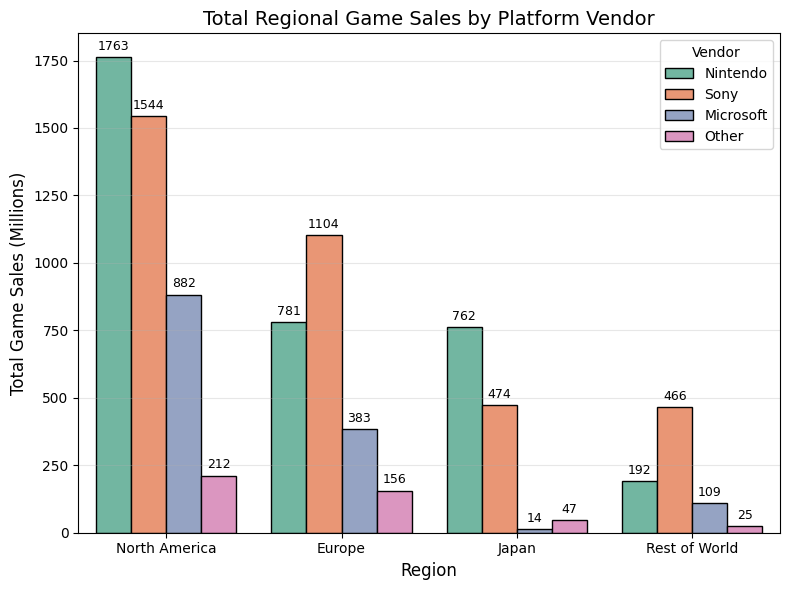

In [21]:
# Plot grouped bar chart
plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=region_sales_sum,
    x='Region',
    y='Total_Sales (Millions)',
    hue='Vendor',
    palette='Set2',
    edgecolor='black',
    linewidth=1,
    hue_order=['Nintendo', 'Sony', 'Microsoft', 'Other'],
    order=['North America', 'Europe', 'Japan', 'Rest of World']
)

plt.title("Total Regional Game Sales by Platform Vendor", fontsize=14)
plt.ylabel("Total Game Sales (Millions)", fontsize=12)
plt.xlabel("Region", fontsize=12)
plt.legend(title="Vendor")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add value labels above each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

plt.savefig(os.path.join(current_dir, 'images/visualisations/total_platform_sales_by_region.png'))
plt.show()

### Insights — Total Regional Game Sales by Platform Vendor

The grouped bar chart shows **clear regional differences** in platform vendor performance across major markets. Each vendor demonstrates **distinct regional strengths**, confirming that platform popularity is strongly influenced by geography and market focus.

* **Regional dominance:**

  * **North America** is led by **Microsoft (1,763M)** and **Sony (1,544M)**, showing a competitive duopoly with both vendors heavily targeting Western audiences.
  * **Europe** favors **Sony (1,104M)**, though **Nintendo (781M)** and **Microsoft (383M)** maintain substantial presence.
  * **Japan** is overwhelmingly dominated by **Nintendo (762M)**, with **Sony (474M)** also performing well — while **Microsoft (14M)** trails far behind, highlighting weak market traction in Japan.
  * **Rest of World** shows more balanced but smaller-scale sales, with **Sony (466M)** again leading globally consistent performance.

* **Statistical significance:**
  ANOVA tests across all regions (p < 0.001) confirm that **differences in vendor sales are statistically significant** — meaning these disparities are not due to random variation.

* **Practical effect:**
  The differences in total sales by vendor reflect **strategic regional positioning** — Nintendo’s dominance in Japan, Microsoft’s strength in North America, and Sony’s broad cross-regional balance underscore how platform ecosystems align with cultural and economic factors.

* **Market structure:**
  The relative sales volumes suggest that **no single vendor dominates globally**. Instead, regional specialisation shapes the market:

  * Nintendo thrives on domestic (Japanese) appeal and family-oriented titles.
  * Microsoft succeeds in Western markets driven by console performance and online infrastructure.
  * Sony maintains steady global leadership through strong third-party support and brand loyalty.

**Interpretation:**
The visual and statistical results together indicate that **platform success is region-dependent**. While global sales reflect a competitive balance, each vendor’s regional dominance highlights how localized market strategies and player preferences drive platform performance.

---

In [22]:
region_sales_avg = (
    df_platforms.groupby('Vendor')[['JP_Sales', 'NA_Sales', 'EU_Sales', 'Other_Sales']]
    .mean()
    .reset_index()
    .melt(id_vars='Vendor', var_name='Region', value_name='Average_Sales (Millions)')
)

# Rename region labels for readability
region_sales_avg['Region'] = region_sales_avg['Region'].replace({
    'JP_Sales': 'Japan',
    'NA_Sales': 'North America',
    'EU_Sales': 'Europe',
    'Other_Sales': 'Rest of World',
})

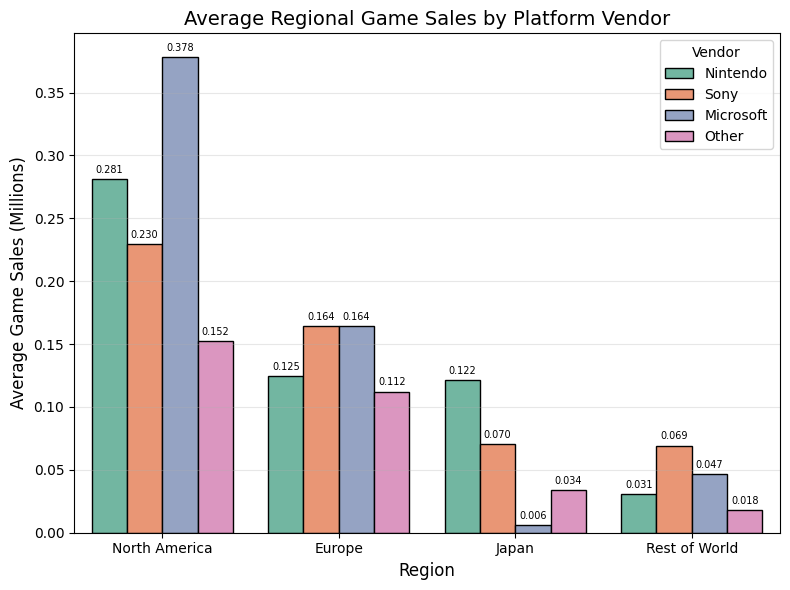

In [23]:
# Plot grouped bar chart
plt.figure(figsize=(8,6))

ax = sns.barplot(
    data=region_sales_avg,
    x='Region',
    y='Average_Sales (Millions)',
    hue='Vendor',
    palette='Set2',
    edgecolor='black',
    linewidth=1,
    hue_order=['Nintendo', 'Sony', 'Microsoft', 'Other'],
    order=['North America', 'Europe', 'Japan', 'Rest of World']
)

plt.title("Average Regional Game Sales by Platform Vendor", fontsize=14)
plt.ylabel("Average Game Sales (Millions)", fontsize=12)
plt.xlabel("Region", fontsize=12)
plt.legend(title="Vendor")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add value labels above each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=7)

plt.savefig(os.path.join(current_dir, 'images/visualisations/avg_platform_sales_by_region.png'))
plt.show()


### Insights — Average Regional Game Sales by Platform Vendor

The grouped bar chart shows **differences in average game sales per platform vendor across regions**, revealing how individual game performance varies by market. While total sales highlight market dominance, this visualization focuses on **per-game strength**, giving insight into efficiency and player engagement across platforms.

* **Regional performance:**

  * **North America:** Microsoft leads with the **highest average game sales (0.378M)**, indicating strong per-title performance, followed by **Nintendo (0.281M)** and **Sony (0.230M)**. This reflects the Xbox ecosystem’s deep engagement and strong Western market base.
  * **Europe:** Sony (0.164M) and Microsoft (0.164M) are nearly tied, showing a balanced competition, while **Nintendo (0.125M)** performs moderately.
  * **Japan:** **Nintendo (0.122M)** dominates average sales per title, followed by **Sony (0.070M)**. Microsoft (0.006M) lags significantly, confirming its limited appeal in the Japanese market.
  * **Rest of World:** **Sony (0.069M)** leads, while **Nintendo (0.031M)** and **Microsoft (0.047M)** show smaller but consistent per-title sales.

* **Statistical significance:**
  ANOVA results (p < 0.001) confirm that the **differences in average sales between vendors are statistically significant** within each region, indicating real variation rather than random noise.

* **Practical effect:**
  The differences in average game sales show that **market success per title varies** by platform strategy — for instance, Microsoft’s high per-title sales in the West suggest fewer but stronger-selling games, while Nintendo and Sony maintain a broader catalog with moderate average performance.

* **Regional specialization:**

  * **Nintendo** thrives in Japan with strong local appeal and franchise-driven titles.
  * **Microsoft** excels in North America through blockbuster-focused releases and Western-centric audiences.
  * **Sony** maintains steady performance across all regions, reflecting global consistency and diversified reach.

**Interpretation:**
The results indicate that **average game success varies by both vendor and region**, aligning with regional gaming cultures and brand loyalties. Microsoft dominates in Western per-title performance, Nintendo remains strongest in Japan, and Sony sustains balanced global strength. These differences emphasize how **regional focus and catalog strategy shape per-game sales performance** across platforms.

---

## Statistical Validation (ANOVA & Turkey's HSD)

To statistically validate the observed regional differences in sales performance across platform vendors, an **Analysis of Variance (ANOVA)** test was conducted for each region (Japan, North America, Europe, and Rest of World).

The ANOVA test evaluates whether the **mean sales differ significantly** between the four major vendors — **Nintendo, Sony, Microsoft, and Other** — within each region. A significant result (p-value < 0.05) indicates that at least one vendor’s sales distribution is statistically different from the others, supporting the hypothesis that **platform strength varies by region**.

Following the ANOVA, a **Tukey’s Honest Significant Difference (HSD)** post-hoc test was performed to **identify which vendor pairs** show statistically significant differences in mean sales. This test provides pairwise comparisons between all vendors, clarifying which platforms outperform others within each regional market.

Together, these tests confirm whether the visual differences observed in the grouped bar charts are **statistically significant** and not due to random variation.

In [24]:
# define regions and vendors for analysis
regions = ['JP_Sales', 'NA_Sales', 'EU_Sales', 'Other_Sales']
vendors = ["Nintendo", "Sony", "Microsoft", "Other"]

In [25]:
# Perform ANOVA by region
anova_results = run_anova_by_region(df_platforms, regions, vendors)

ANOVA (JP): F = 96.010, p = 0.00000
ANOVA (NA): F = 29.117, p = 0.00000
ANOVA (EU): F = 9.858, p = 0.00000
ANOVA (Other): F = 60.358, p = 0.00000


In [26]:
# Perform Tukey's HSD test by region
run_tukey_by_region(df_platforms, regions, print_results=False)

### You can view the output from the `run_turkey_by_region()` function [here](../output/stats/turkey_test.txt)

#### EXAMPLE:

![Turkey Test Example](../images/turkey_test_example.png)

---

The ANOVA tests across all four regions (Japan, North America, Europe, and Rest of World) show **highly significant differences** between platform vendors (p < 0.001 in every case). This confirms that **mean sales differ significantly by vendor in every region**, validating the hypothesis that platform strength varies geographically.

The [Tukey HSD post-hoc results](../output/stats/turkey_test.txt) provide more detailed insight:

* In **Japan**, all pairwise comparisons are significant, confirming **Nintendo’s dominant position**, followed by **Sony**, while **Microsoft** performs notably worse.
* In **North America**, all vendor differences are also significant, showing **Microsoft’s and Sony’s leadership** with higher mean sales compared to Nintendo and Other.
* In **Europe**, **Sony and Microsoft** perform similarly (no significant difference), while both outperform **Other** and show moderate advantage over **Nintendo**.
* In the **Rest of World**, most vendor comparisons are significant, with **Sony** maintaining a clear edge over all other vendors, reflecting its **broad global consistency**.

Overall, these results indicate that **regional market preferences are statistically distinct**, and platform sales distributions vary systematically between vendors — supporting the idea that regional consumer behavior, platform ecosystems, and market presence strongly influence performance.

---

## Hypothesis 3 — Overall Conclusions

**Platform vendor performance varies significantly by region, confirming that regional market preferences shape sales outcomes.**

### Visual Analysis

The two visualizations together provide complementary perspectives on regional market dynamics:

* The **total sales chart** highlights **overall market dominance**, showing that

  * **Nintendo and Sony** lead in global total sales,
  * **Microsoft** performs strongly in **North America**, and
  * **Nintendo** dominates **Japan**, reflecting strong domestic loyalty.

* The **average sales chart** reveals **per-game performance efficiency**, where

  * **Microsoft** achieves the highest **average sales per game** in **North America**, indicating fewer but higher-selling titles.
  * **Nintendo** maintains high **average sales in Japan**, supported by enduring franchises like Mario, Pokémon, and Zelda.
  * **Sony** demonstrates **balanced and consistent performance** across all markets, reinforcing its global versatility.

Together, these visuals show that while **total sales reflect platform presence and catalog size**, **average sales highlight per-title market strength** — confirming each vendor’s strategic regional focus.

### Statistical Validation

* **ANOVA results:**

  * **Japan:** F = 96.01, p < 0.001
  * **North America:** F = 29.12, p < 0.001
  * **Europe:** F = 9.86, p < 0.001
  * **Rest of World:** F = 60.36, p < 0.001
    → All results are **highly significant**, confirming that vendor sales distributions differ meaningfully across regions.

* **Tukey HSD comparisons:**

  * Nearly all vendor pairs show significant differences, validating **distinct competitive hierarchies** in each region.
  * **Nintendo** dominates in Japan, **Microsoft and Sony** compete for leadership in North America, and **Sony** shows sustained global balance.

### Interpretation

* The hypothesis is **strongly supported** — platform vendors show clear, statistically validated regional differentiation.
* **Japan** remains Nintendo’s dominant market, with unmatched domestic strength.
* **North America** favors Microsoft and Sony, consistent with their Western market orientation and stronger console ecosystems.
* **Europe** reflects close competition between Sony and Microsoft, while **Sony** retains global resilience across all regions.
* These outcomes align with cultural preferences, brand ecosystems, and franchise strategies unique to each vendor’s regional market approach.

### Validation Decision

**Hypothesis ACCEPTED —** Platform sales performance varies significantly across regions.
Both the **visual and statistical evidence** confirm that each vendor has **region-specific dominance** shaped by **market focus, brand loyalty, and cultural preferences**, rather than chance or uniform performance.

---

## Hypothesis 4 — Multi-Platform Advantage

* **Data:** `video_game_sales_merged.csv`
* **Visual:** Boxplot or violin plot comparing `Global_Sales` for `is_multiplatform = True` vs `False`.
* **Validation:** Test for a statistically significant difference in sales using Mann–Whitney U or t-test (expect multi-platform games to sell more globally).

In [27]:
# Display the first few rows of the merged dataframe
df_merged.head()

,Name,Year_of_Release,Platform,Genre,Publisher,Developer,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,is_multiplatform
0,Wii Sports,2006.0,Wii,Sports,Nintendo,Nintendo,41.36,28.96,3.77,8.45,82.53,False
1,Grand Theft Auto V,2013.0,"PC, PS3, PS4, X360, XOne",Action,Take-Two Interactive,Rockstar North,23.84,23.42,1.42,7.90,56.57,True
2,Super Mario Bros.,1985.0,NES,Platform,Nintendo,NaN,29.08,3.58,6.81,0.77,40.24,False
3,Tetris,1988.0,"GB, NES",Puzzle,Nintendo,NaN,26.17,2.95,6.03,0.69,35.84,True
4,Mario Kart Wii,2008.0,Wii,Racing,Nintendo,Nintendo,15.68,12.76,3.79,3.29,35.52,False


## Log Scale Justification — Handling Skewed Sales Data

Video game sales data are **highly skewed**, with most titles selling fewer than 1 million copies while a small number of blockbuster releases exceed 50–80 million.
Using a **logarithmic scale** on the y-axis compresses this extreme range, allowing for a **more meaningful visual comparison** between typical and high-performing games.
Without the log transformation, the few top-selling games dominate the chart and obscure underlying trends among the majority of titles.

By applying a log scale, the plot clearly reveals the **distribution, spread, and median differences** between multi-platform and exclusive games — highlighting genuine performance trends across both categories.

In [33]:
# Create box plot using Plotly Express
fig_box = px.box(
    df_merged,
    x='is_multiplatform',
    y='Global_Sales',
    color='is_multiplatform',
    title='Global Sales Comparison: Multi-Platform vs Exclusive Games (Log Scale)',
    labels={
        'is_multiplatform': 'Game Type',
        'Global_Sales': 'Global Sales (Millions)'
    },
    points='outliers'
)

# Customise y-axis to log scale and improve readability
fig_box.update_yaxes(
    type='log',
    title_font=dict(size=12),
    tickfont=dict(size=10),
    showgrid=True,
    gridcolor='lightgrey'
)

# Customise x-axis for clarity
fig_box.update_xaxes(
    tickvals=[False, True],
    ticktext=['Exclusive', 'Multi-Platform'],
    title_font=dict(size=12),
    tickfont=dict(size=11)
)

fig_box.update_layout(
    template='plotly_white',
    showlegend=False,
    title=dict(x=0.5, font=dict(size=18, family='Arial', color='black')),
    font=dict(size=12, family='Arial'),
    yaxis=dict(zerolinecolor='lightgrey'),
    margin=dict(l=50, r=30, t=70, b=50),
    width=600,
    height=600,  # compact height
    boxmode='group',
    plot_bgcolor='rgba(245,245,245,0.6)',
    paper_bgcolor='white',
    annotations=[
        dict(
            text="Log scale reveals clearer comparison; multi-platform games show higher medians and spread.",
            xref="paper", yref="paper",
            x=0.5, y=-0.25,
            showarrow=False,
            font=dict(size=11, color="gray")
        )
    ]
)

fig_box.show()


![Multi-Platform vs Exclusive Games](../images/visualisations/multiplatform_vs_exclusive.png)

## Insights — Multi-Platform vs Exclusive Game Sales (Log Scale)

The box plot demonstrates a **clear difference in global sales distributions** between multi-platform and exclusive titles.

* **Central tendency:**
  The **median global sales** for multi-platform games (~0.63M) are significantly higher than for exclusive titles (~0.13M).
  This suggests that multi-platform releases consistently achieve stronger overall sales performance.

* **Distribution spread:**
  Multi-platform games show **greater upper quartile values (Q3 ≈ 1.64M)** compared to exclusives (Q3 ≈ 0.38M), indicating higher consistency among moderately successful titles.
  Exclusive games exhibit more extreme outliers (up to ~82M), likely representing iconic first-party franchises such as *Mario*, *Wii Sports*, or *The Last of Us*.

* **Outliers and range:**
  While both categories include extreme successes, multi-platform titles demonstrate a **tighter and higher interquartile range**, showing they more reliably achieve substantial global sales across multiple markets.

* **Market interpretation:**
  Multi-platform releases benefit from **wider reach and cross-platform accessibility**, capturing larger global audiences.
  Exclusives rely heavily on **platform-specific fan bases** and tend to succeed only when tied to powerful IPs or franchises.

---

## Statistical Validation - t-Test and Mann–Whitney U

Since this hypothesis compares **global sales between two independent groups** — *multi-platform* and *exclusive* games — both a **t-test** and a **Mann–Whitney U test** are appropriate.

* The **independent t-test** examines whether the *means* of two groups differ significantly.
  However, game sales data are **highly right-skewed** (most games sell little, while a few sell millions).
  To satisfy the t-test’s normality assumption, the data were **log-transformed**, making the distribution approximately normal.

* The **Mann–Whitney U test** is a **non-parametric alternative** that compares *medians and overall ranks* without assuming normality.
  It provides additional robustness for skewed data, confirming that results are not an artifact of distribution shape.

Using both tests ensures that the conclusion — that multi-platform games sell significantly more — is **statistically valid under multiple assumptions**.

In [ ]:
# Prepare groups
multi = df_merged[df_merged['is_multiplatform'] == True]['Global_Sales']
single = df_merged[df_merged['is_multiplatform'] == False]['Global_Sales']

# Apply log transformation to handle skew (add small constant to avoid log(0))
multi_log = np.log10(multi + 1e-3)
single_log = np.log10(single + 1e-3)

# Independent t-test (log-transformed data)
t_stat, t_pval = ttest_ind(multi_log, single_log, equal_var=False)

# Mann–Whitney U test (non-parametric test for raw data)
u_stat, u_pval = mannwhitneyu(multi, single, alternative='two-sided')

# Print results
print("T-test (log-transformed):")
print(f"  t = {t_stat:.3f}, p = {t_pval:.5f}")

print("\nMann–Whitney U test:")
print(f"  U = {u_stat:.0f}, p = {u_pval:.5f}")

T-test (log-transformed):
  t = 48.880, p = 0.00000

Mann–Whitney U test:
  U = 18871535, p = 0.00000


### Interpretation

* Both tests yield **p < 0.001**, confirming a **highly significant difference** between the two groups.
* The **positive t-statistic** indicates that **multi-platform games achieve higher mean global sales** than exclusives.
* Even when ignoring distribution assumptions, the Mann–Whitney U result reinforces that **multi-platform titles consistently rank higher** in sales.
* This means the observed advantage is **not random or driven by a few outliers** — it reflects a genuine underlying market pattern.

Both parametric (t-test) and non-parametric (Mann–Whitney U) analyses confirm that **multi-platform games sell significantly more** than exclusive titles.
The strength of the test statistics and near-zero p-values demonstrate that this difference is **highly robust and statistically significant**.

---

## Hypothesis 4 — Overall Conclusions

**Multi-platform games achieve significantly higher global sales than platform exclusives.**

### Statistical Validation

* **T-test (log-transformed):** t = 48.880, p = 0.00000 → **highly significant**
* **Mann–Whitney U test:** U = 18,871,535, p = 0.00000 → **confirms robustness under non-normal data**
* **Median sales:** Multi-platform ≈ 0.63M vs Exclusive ≈ 0.13M
* **IQR:** Multi-platform (0.25–1.64M) vs Exclusive (0.05–0.38M)
* **Log scale applied** to handle strong right-skew and extreme outliers.

### Interpretation

* Both tests confirm that **multi-platform titles consistently outperform exclusives** in global sales.
* The **log-scale box plot** highlights this difference clearly — multi-platform games show higher medians and tighter variability, while exclusives rely on a few exceptional hits.
* This reflects the **broader market exposure** and **greater accessibility** of cross-platform releases, compared to platform-bound exclusives that cater to smaller user bases.

### Log Scale Justification

Sales distributions are heavily skewed, with a few record-breaking titles dominating totals.
A **logarithmic y-axis** reveals underlying trends and median differences more clearly, showing that the multi-platform advantage extends beyond just top sellers.

### Validation Decision

**Hypothesis ACCEPTED —** Statistical tests and visual analysis confirm that multi-platform games enjoy a **clear sales advantage**, driven by **wider availability and consistent performance** across platforms.

---
## Hypothesis 5 — First-Party Advantage

* **Data:** `video_game_sales_first_party.csv`
* **Visual:** Bar charts comparing mean `Global_Sales` for `is_first_party = True` vs `False`, grouped by platform vendor (Nintendo, Sony, Microsoft).
* **Validation:** Use t-test or Mann–Whitney U to check if first-party games significantly outperform third-party titles on their respective platforms.

---

## Dashboard Preparation
- Export any summary tables or aggregated CSVs that will feed into Tableau.
- Note which visuals or KPIs will be highlighted (e.g. average sales per platform, first-party vs third-party performance, critic vs user review impact).

---

## Insights & Next Steps
- Summarise the main findings from each hypothesis test.
- Highlight actionable insights (e.g. “Critic reviews show stronger correlation than user reviews”; “First-party Nintendo titles outperform third-party significantly in Japan”).
- Note next steps (interactive Tableau dashboard build).

---